# Named entity classification with a custom RNN 🧠
I aimed to train an RNN that distinguishes named entities from common words.

I followed [Patrick Loeber](https://www.youtube.com/watch?v=WEV61GmmPrk)'s tutorial, based on this [pytorch.org](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) blog post to create and train the model.

As for the training data, I wrote a few samples by hand (no more than 30) and generated the rest using GPT 3.5 (looking back, it's crazy to see how well the model performed even with such a limited amount of data, especially considering it's almost entirely synthetic!)

## What I learned
Entropy is hard to challenge.
I first tried to use this exact dataset but separated into categories (people, places, organizations) to try and train a model that can distinguish between the three. However, I couldn't get to a loss lower than 0.3 - the model performed equivalent to random guessing. 
After consulting with a few of my uni professors, I was told to:
1. simply try classifying between normal words and entities first
2. get way more training data

I really did not want to look for more training data, so I ended up training the model to classify between normal words and entities. And it did great!   

## 1. Preprocessing raw training data

In [1]:
import os
import io
import glob
import unicodedata
import string

base_file_path = "./dataset"

def findFiles(path): return glob.glob(path)


Almost every entry in the dataset was generated by GPT 3.5 🤯

Therefore, the data needs to be processed and normalized, removing duplicate entries for example.

In [2]:
# Starting from raw data for each classification category (entity.txt, none.txt)
# Remove duplicate and normalize entries.

datasets = findFiles(base_file_path+'/*.txt')

ALL_LETTERS = string.ascii_letters + ".,; "
N_LETTERS = len(ALL_LETTERS)

def normalize(entry):
  entry_stripped = entry.split(" ")
  entry = entry_stripped[0] if len(entry_stripped) > 0 else ""
  return ''.join(
      c for c in unicodedata.normalize('NFD', entry)
      if unicodedata.category(c) != 'Mn'
      and c in ALL_LETTERS
  )

def process_lines(filename):
    # Normalize dataset entries
    n=0
    lines_clean = []
    lines = io.open(filename,  encoding="utf-8").read().split('\n')
    for line in lines:
        line = normalize(line)
        if line not in lines_clean:
          lines_clean.append(line)
        n += 1

    # print(len(lines_clean), n)
    return lines_clean, n

In [3]:
# Utils, preprocess data

def load_data():
  category_lines = {}
  all_categories = []

  for filename in datasets:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines, n = process_lines(filename)
    category_lines[category] = lines

  return category_lines, all_categories

In [4]:
# Let's try the dataset...

category_lines, all_categories = load_data()
print(category_lines["entity"][:5])

['Nueva', 'Paris', 'Londres', 'Tokio', 'Roma']


## 2. Defining tensors, encoding, and model architecture
The dataset is ready. Now we move on to defining tensors and specific parts of the RNN before defining the model itself.

This classification model is going to be character-based and will use one-hot encoding to represent letters and words numerically as tensors.

In [5]:
import torch
import random

"""
To represent a single character we use a "one-hot vector"
of size <1 x amt_letters>.

To represent a word, we stuff as many of those vectors as needed inside a 
2D matrix <line_len x 1 x amt_letters>, where 1 is the batch size
"""

# Find letter index in all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Turn letter into tensor <1 x n_letters>
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn line into <line_length x 1 x n_letters>,
# a one-hot letter vector array
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# Get random training sample
def random_training_sample(category_lines, all_categories):

    def random_choice(a):
        random_index = random.randint(0, len(a) - 1)
        return a[random_index]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

print(letter_to_tensor("a"))
print(line_to_tensor("Juan").size())



tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([4, 1, 56])


Finally, the model itself 🤓

![Una RNN vanilla en Pytorch](images/pytorch-vanilla-rnn.png)

In [6]:
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # input to hidden layer
        self.i20 = nn.Linear(input_size + hidden_size, output_size) # input to output layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        """
        Se entiende mejor viendo el gráfico de RNN!
        """
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i20(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
      return torch.zeros(1, self.hidden_size)


With our RNN already defined, we can instantiate a model and perform a single training step manually!


In [7]:
# category_lines, all_categories = load_data()

n_categories = len(all_categories)

# Initialize new model with 64 hidden layers
n_hidden = 64
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# Perform a single training step
input_tensor = letter_to_tensor("a")
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor, hidden_tensor) # Forward pass

print(output.size())
print(next_hidden.size())

torch.Size([1, 2])
torch.Size([1, 64])


## 3. Training 
Now, on to training 🏋️

none
0 0.0% 0.6470 su | none CORRECT
5000 8.7% 0.6586 recuperacion | none CORRECT
10000 17.4% 0.7923 sastre | entity WRONG | none
15000 26.1% 0.4996 Viedma | entity CORRECT
20000 34.8% 0.5479 Nicole | entity CORRECT
25000 43.5% 0.9320 Chamorro | none WRONG | entity
30000 52.2% 0.5290 Ulan | entity CORRECT
35000 60.9% 0.4856 UNESCO | entity CORRECT
40000 69.6% 0.4151 Piura | entity CORRECT
45000 78.3% 0.5602 conferencia | none CORRECT
50000 87.0% 0.0073 Colima | entity CORRECT
55000 95.7% 0.0253 papel | none CORRECT


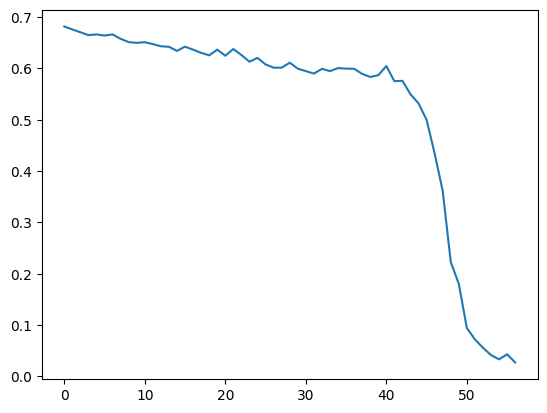

Final loss: 0.0271


In [8]:
# Return the most probable category
def category_from_output(output):
    category_index = torch.argmax(output).item()
    return all_categories[category_index]

print(category_from_output(output))

criterion = nn.NLLLoss() # Negative log-likelihood
learning_rate = 0.0008
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)  # Stochastic gradient descent

# A training step
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 57500

# Training!
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_sample(category_lines, all_categories)

    while category == "" or line == "" or torch.isnan(category_tensor):
      category, line, category_tensor, line_tensor = random_training_sample(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if i % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG | {category}"
        print(f"{i} {(i/n_iters*100):.1f}% {loss:.4f} {line} | {guess} {correct}")

# Plot loss
plt.figure()
plt.plot(all_losses)
plt.show()

print(f"Final loss: {all_losses[-1]:.4f}")

#### We can finally test the model 🎉

In [ ]:
# Inference!
def predict(input_line):
  with torch.no_grad():
      line_tensor = line_to_tensor(input_line)

      hidden = rnn.init_hidden()

      for i in range(line_tensor.size()[0]):
          output, hidden = rnn(line_tensor[i], hidden)

      return category_from_output(output)

while True:
  input_line = input()
  if input_line == "quit":
    break

  prediction = predict(input_line)

  if prediction:
    print(predict(input_line) + "\n")

We can test it and verify it works well with words not included in the dataset 🤙

The _loss_ is pretty decent (<0.03), though it would be necessary to expand the dataset separating training from validation to take it seriously 

We still need to test different hyperparameters (here's an [interesting cheatsheet](https://gist.github.com/DavidIsrawi/6c45744c12a4f8fc08bd5b8f7f9e06d8)), but most importantly, get better data.

### Now we save the model for later 💾

Using `torch.save()`, which stores all model gradients (su `state_dict`) and extra data needed for inference.

This allows us to load and inference the pre-trained model from a different script in the future.


In [ ]:
# Save the model to the "model.pth" file
torch.save(rnn.state_dict(), base_file_path + "/model.pth")

# Load the mdel from that file
rnn_2 = RNN(N_LETTERS, n_hidden, n_categories)
rnn_2.load_state_dict(torch.load(base_file_path + "/model.pth"))
rnn_2.eval()
